In [1]:
import json
import numpy as np
from GRID import GRID
import matplotlib.pyplot as plt
import sys

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:

# Keys = ['0']
Keys = ['0', '1', '2', '3', '4', '5', '6']
StationTicks = np.arange( 0, len(Keys) )
StationLabels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 
				 'H', 'I', 'J', 'K', 'L', 'M', 'N',
				 'O', 'P', 'Q',		 'R', 'S', 'T',
				 'U', 'V', 'W', 	 'X', 'Y', 'Z']


In [3]:
# fp: "fp32", "fp16", "half2"
# var: "Vx", "Vy", "Vz"

def readData(fp, var):

	# parameters json file and grid configuaration
	jsonsFile = open( "../paramsDir/paramsCGFDM3D_%s.json" % fp)
	params = json.load( jsonsFile )
	grid = GRID( params )

	DT = params["DT"]
	TMAX = params["TMAX"]
	NT = int( params["TMAX"] / params["DT"] ) - 1
	# print("NT=%d" % NT)
	t = np.linspace( 0, params["TMAX"], NT )

	# stations json file
	stationFile = open( "../stationsDir/station.json" )
	stationDir = json.load( stationFile )
	station = stationDir["station(point)"]

	fileName = "../%s/station" % params["out"]

	WAVESIZE = 9

	mpiX = -1
	mpiY = -1
	mpiZ = -1

	PX = grid.PX
	PY = grid.PY
	PZ = grid.PZ

	stationNum = np.zeros( [PZ, PY, PX], dtype = 'int32' ) 
	stationData = { }

	# varDir = { "Vx" : 0, "Vy" : 1, "Vz" : 2, "Txx" : 3, "Tyy" : 4, "Tzz" : 5, "Txy" : 6, "Txz" : 7, "Tyz" : 8 }

	# stations loop
	for index in station.values( ):
		X = index[0]
		Y = index[1]
		Z = index[2]

		# MPI block loop
		for mpiZ in range( grid.PZ ):
			for mpiY in range( grid.PY ):
				for mpiX in range( grid.PX ):
					thisX = X - grid.frontNX[mpiX] + grid.halo
					thisY = Y - grid.frontNY[mpiY] + grid.halo
					thisZ = Z - grid.frontNZ[mpiZ] + grid.halo
					if thisX >= grid.halo and thisX < grid._nx[mpiX] and \
						thisY >= grid.halo and thisY < grid._ny[mpiY] and \
							thisZ >= grid.halo and thisZ < grid._nz[mpiZ]:
						stationNum[mpiZ, mpiY, mpiX] += 1	# indicate station number in this MPI block

	stationForDrawNum = len( Keys )
	U  = np.zeros( [ stationForDrawNum, NT ] )
	Ux = np.zeros( [ stationForDrawNum, NT ] )
	Uy = np.zeros( [ stationForDrawNum, NT ] )
	Uz = np.zeros( [ stationForDrawNum, NT ] )

	stationKeyNum = { }

	num = 0
	for mpiZ in range( grid.PZ ):
		for mpiY in range( grid.PY ):
			for mpiX in range( grid.PX ):
				if stationNum[mpiZ, mpiY, mpiX] != 0:
					FileName = "%s_mpi_%d_%d_%d.bin" % ( fileName, mpiX, mpiY, mpiZ )
					File = open( FileName, "rb" )
					# print( FileName )
					count = stationNum[mpiZ, mpiY, mpiX]	# station number
					XIndex = np.fromfile( File, dtype='int32', count = count )
					YIndex = np.fromfile( File, dtype='int32', count = count )
					ZIndex = np.fromfile( File, dtype='int32', count = count )

					count = NT * stationNum[mpiZ, mpiY, mpiX] * WAVESIZE
					data = np.fromfile( File, dtype='float32', count = count )
					dataRe = np.reshape( data, ( WAVESIZE, stationNum[mpiZ, mpiY, mpiX], NT ) )	# station wave data
					stationData[( mpiX, mpiY, mpiZ )] = dataRe
					for key in Keys:
						xidx = station[key][0]	# x, y, z grid points location
						yidx = station[key][1]
						zidx = station[key][2]
						# print( "key = %s, X = %d, Y = %d, Z = %d" % ( key, xidx, yidx, zidx ) )
						for i in range( stationNum[mpiZ, mpiY, mpiX] ):
							Ux_ = np.zeros( NT )
							Uy_ = np.zeros( NT )
							Uz_ = np.zeros( NT )

							Ux_ = dataRe[0, i, :]	# Vx
							Uy_ = dataRe[1, i, :]	# Vy
							Uz_ = dataRe[2, i, :]	# Vz

							if xidx == XIndex[i] and yidx == YIndex[i] and zidx == ZIndex[i]:
								Ux[num] = Ux_
								Uy[num] = Uy_
								Uz[num] = Uz_

								stationKeyNum[key] = num
								num += 1


	if var == 'Vx':
		U = Ux
	else:
		if var == 'Vy':
			U = Uy
		else:
			if var == 'Vz':
				U = Uz	
			else:
				U = U + 1

	return U, stationKeyNum

In [4]:
jsonsFile = open( "../paramsDir/paramsCGFDM3D_fp32.json" )
params = json.load( jsonsFile )

DT = params["DT"]
TMAX = params["TMAX"]
NT = int( params["TMAX"] / params["DT"] ) - 1
print("NT=%d" % NT)
t = np.linspace( 0, params["TMAX"], NT )

# stations json file
stationFile = open( "../stationsDir/station.json" )
stationDir = json.load( stationFile )
station = stationDir["station(point)"]


def plotSeis(var, ax):
	U_1, stationKeyNum_1 = readData("fp32", var)
	U_2, stationKeyNum_2 = readData("half2", var)

	base = 0
	stride = 0.05
	mul = 10
	flag = True

	for key in station.keys( ):
		#print( key )
		for iKey in Keys:
			if key == iKey:
				# print( key )

				i = stationKeyNum_1[key]
				# print(U[i].shape)

				# ax.plot( t, U_1[i]+base, color='r', linewidth=1, ls = '-', label="float")
				ax.plot( t, U_1[i]+base, color='r', ls = '-', label="float")
				ax.plot( t, U_2[i]+base, color='b', ls = '--', label="half2")
				# ax.plot( t, (U0[i] - U[i]) * mul + base , color = 'g', ls = ':', label="error")
				ax.plot( t, (U_1[i] - U_2[i]) + base, color = 'g', ls = ':', label="error")
				# ax.scatter( t, U0[i] - U[i] , color = 'g', s=0.1, label="res")

				if (flag == True):
					ax.legend(loc="upper right", fontsize="small", frameon=False, ncol=3)
					
					flag = False
				
				# ax.set_title("sta" + str(key))
				base += stride

				break

	ax.set_xlabel("Time (s)")
	ax.set_ylabel("Stations")

	# ax.set_ylabel("Vx")
	# ax.set_title("layered half space: %s" % var)
	ax.set_title("Gaussian hill model: %s" % var)
	ax.set_xlim([0, TMAX])
	# ax.set_ylim( [-1.5*stride, base + stride/2] )	
	ax.set_ylim( [-1.0*stride, base] )
	ax.set_yticks( StationTicks[:len(Keys)] * stride,  StationLabels[:len(Keys)])


def plotSeis_sharex(var, axList):
	U_1, stationKeyNum_1 = readData("fp32", var)
	U_2, stationKeyNum_2 = readData("half2", var)
	U_1 *= 1000
	U_2 *= 1000

	idx = 0
	for key in station.keys( ):
		#print( key )
		for iKey in Keys:
			if key == iKey:
				# print( key )

				i = stationKeyNum_1[key]
				# print(U[i].shape)

				axList[idx].plot( t, U_1[i], color='r', linewidth=1.2, ls = '-', label="FP32" if (var == "Vx" and idx == 0) else '_nolegend_')
				axList[idx].plot( t, U_2[i], color='b', linewidth=1.2, ls = '--', label="FP16" if (var == "Vx" and idx == 0) else '_nolegend_')
				axList[idx].plot( t, (U_1[i] - U_2[i]), color = 'g', linewidth=1.2, ls = ':', label="error" if (var == "Vx" and idx == 0) else '_nolegend_')

				number = 1.1 * max(abs(U_1[i]))
				decimal_places = len(str(number).split('.')[-1])
				multiplier = 10 ** decimal_places
				vmax = round(number * multiplier) / multiplier

				if (idx == 6):
					axList[idx].set_xlabel("Time (s)")
				
				if (var == "Vx"):
					strnm = "$v_x$ (mm/s)"
				elif (var == "Vy"):
					strnm = "$v_y$ (mm/s)"
				elif (var == "Vz"):
					strnm = "$v_z$ (mm/s)"

				if (idx == 0):
					axList[idx].set_title(strnm)

				if (var == "Vx"):
					axList[idx].set_ylabel("Sta-" + StationLabels[i])

				# axList[idx].set_yticks( np.linspace(-vmax, vmax, 3) )
				axList[idx].set_ylim([-vmax, vmax])

				idx += 1

	# # ax.set_title("layered half space: %s" % var)
	# ax.set_title("Gaussian hill model: %s" % var)


NT=2999


In [5]:
# picname = "gaussTopo"

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
# plotSeis("Vx", ax1)
# plotSeis("Vy", ax2)
# plotSeis("Vz", ax3)

# plt.savefig("PDF/%s.pdf" % picname, dpi=500, bbox_inches = "tight")

Text(0.5, 0.95, 'Gaussian topography model')

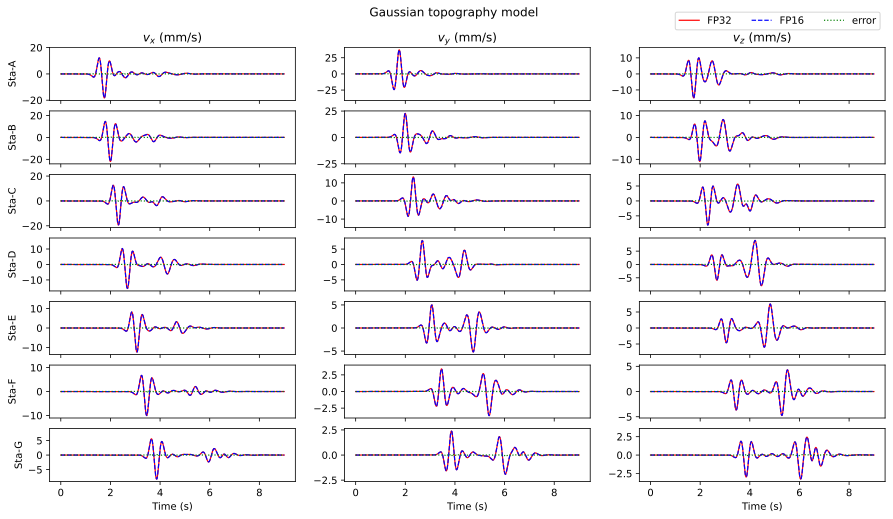

In [6]:
picname = "gaussTopo"
# picname = "layerHalf"

row = len(Keys)
col = 3

fig, axArray = plt.subplots(row, col, figsize=(15, 8), sharex=True)

plotSeis_sharex("Vx", axArray[:, 0])
plotSeis_sharex("Vy", axArray[:, 1])
plotSeis_sharex("Vz", axArray[:, 2])

fig.legend(fontsize="medium", loc="upper right", bbox_to_anchor=(0.9, 0.95), ncol=3)
# fig.legend(fontsize="medium", loc="upper right")
fig.suptitle("Gaussian topography model", x=0.5, y=0.95, ha='center')
# fig.suptitle("Half-space layered model", x=0.5, y=0.95, ha='center')
# plt.savefig("imagesDir/%s.pdf" % picname, dpi=500, bbox_inches = "tight")


In [7]:
# fig, ax = plt.subplots(figsize=(5, 2.5))
# # base = 0
# # stride = 0.135
# mul = 10
# flag = True

# for key in station.keys( ):
# 	#print( key )
# 	for iKey in Keys:
# 		if key == iKey and key == "4":
# 			# print( key )

			
# 			i = stationKeyNum[key]
# 			# print(U[i].shape)

# 			ax.plot( t, U0[i], color='r', ls = '-', label="float")
# 			ax.plot( t, U[i], color='b', ls = '--', label="half2")
# 			# ax.plot( t, (U0[i] - U[i]) * mul + base , color = 'g', ls = ':', label="error")
# 			ax.plot( t, (U0[i] - U[i])*10, color = 'g', ls = ':', label="error X10")
# 			# ax.scatter( t, U0[i] - U[i] , color = 'g', s=0.1, label="res")
# 			# ax.grid()

# 			if (flag == True):
# 				ax.legend(loc="upper right", fontsize="medium", frameon=False)
				
# 				flag = False
			
			
# 			# ax.set_title("sta" + str(key))
# 			# base += stride

# 			break

# ax.set_xlabel("t (s)")
# # ax.set_ylabel("Vx")
# ax.set_title("Gaussian hill model: %s (m/s)" % var)
# ax.set_xlim([0, TMAX])	
# ax.set_ylim( [-0.03, 0.03] )
# ax.grid()
# ax.set_yticklabels(["", -0.2, "","0","",0.2,""])
# # ax.set_yticks( StationTicks[:len(Keys)] * stride,  StationLabels[:len(Keys)])
# plt.savefig("PDF/%s_single.png" % var, dpi=500, bbox_inches = "tight")
# # ax.set_yticklabels( ["", "A", "B", "C", "D", "E", "F", "G", ""] )	

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.fft import fft, fftfreq


# # 采样频率
# fs = 50

# N = len(t)
# yf = fft(U0[0] - U[0])
# xf = fftfreq(N, 1 / fs)[:N // 2]

# # 画图
# # plt.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# # plt.plot(xf, 2.0 / N * yf[0:N // 2])
# plt.scatter(xf, 2.0 / N * np.abs(yf[0:N // 2]), s=2)
# plt.xlabel('Frequency (B:Hz)')
# plt.ylabel('Amplitude (A)')
# plt.grid()
# plt.show()